## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler  
from darts.models import Prophet

F:\Anaconda\envs\MLProjects\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading and Preparaing the Dataset

In [2]:
df = pd.read_csv("../data/Sunspots.csv")

In [3]:
df.drop(columns = ['Unnamed: 0'],inplace=True)
#setting the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

#setting the date column as index
df_idx = df.set_index(['Date'],drop=False)

In [4]:
#converting the necessary datasets used for prediction into TimeSeries objects
act_series_2010 = TimeSeries.from_dataframe(df_idx[:'2009'], 'Date', 'Monthly Mean Total Sunspot Number')  
act_series_2000 = TimeSeries.from_dataframe(df_idx[:'1999'], 'Date', 'Monthly Mean Total Sunspot Number')  
act_series_1990 = TimeSeries.from_dataframe(df_idx[:'1989'], 'Date', 'Monthly Mean Total Sunspot Number')  

## Prophet Model

In [5]:
#building the model
def model_prophet(params):

    def encode_year(idx):
        return idx.year

    add_encoders = {
        'transformer': Scaler(),
        'tz': 'CET',
    }

    #prophet model
    model =  Prophet(
        changepoint_prior_scale =  params['changepoint_prior_scale'],
        add_encoders = add_encoders,
    )

    #adding seasonality
    model.add_seasonality(            
            name = '10_yr_cycle',  # (name of the seasonality component),
            seasonal_periods = 12*11,  # (nr of steps composing a season),
            fourier_order = params['decade_fourier_order'],  # (number of Fourier components to use),
            mode = 'multiplicative',
            prior_scale = params['decade_seasonality_prior_scale']
        )

    model.add_seasonality(
            name= 'yearly_cycle',  # (name of the seasonality component),
            seasonal_periods = 12,  # (nr of steps composing a season),
            fourier_order = params['yearly_fourier_order'],
            mode ='additive',# (number of Fourier components to use),
            prior_scale = params['yearly_seasonality_prior_scale']
    )

    return model

In [6]:
#converting the predicted series into a dataframe more suitable for analysis and comparison with actual values
def forecast_df(pred_series):
    df_pred = TimeSeries.to_dataframe(pred_series)
    df_pred.reset_index(inplace=True)
    df_pred.columns = ['Date','Monthly Mean Sunspot Predicted']
    df_pred['Month'] = df_pred['Date'].dt.to_period('M')
    df_idx['Month'] = df_idx['Date'].dt.to_period('M')
    df_pred = df_pred.merge(df_idx,on='Month',how='left')
    df_pred = df_pred[['Date_x','Monthly Mean Sunspot Predicted','Monthly Mean Total Sunspot Number']]
    df_pred.rename(columns = {'Date_x':'Date','Monthly Mean Total Sunspot Number':'Monthly Mean Sunspot Actual'},inplace=True)
    df_pred['mae'] = abs(df_pred['Monthly Mean Sunspot Actual'] - df_pred['Monthly Mean Sunspot Predicted'])
    df_pred = df_pred.set_index(['Date'],drop=False)
    return df_pred

In [7]:
#visualizing the predictions with the actual values to help access our model
def viz_forecast(df_pred):
    plt.figure(figsize=[12,4])
    plt.plot(df_idx['1960':].index,df_idx['1960':]['Monthly Mean Total Sunspot Number'],label='Actual',color='steelblue')
    plt.plot(df_pred.index,df_pred['Monthly Mean Sunspot Predicted'],label='Predicted',color='#FF6347')
    
    plt.xlabel('Date')
    plt.ylabel('Monthly Mean Sunspots')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title('Predicted vs Actual Monthly Mean Sunspots')
    plt.legend()
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

## Model Prediction for Training Data till 1990

11:18:18 - cmdstanpy - INFO - Chain [1] start processing
11:18:25 - cmdstanpy - INFO - Chain [1] done processing


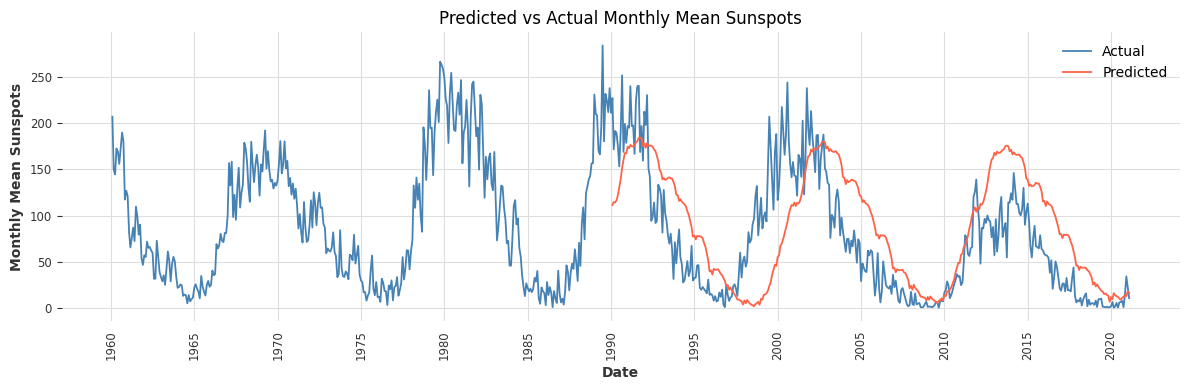

In [8]:
#passing the parameters for the model
#model parameters for training data till 1990
model_params_1990 = {'changepoint_prior_scale': 0.26, 
                    'decade_seasonality_prior_scale': 9.21, 
                    'decade_fourier_order': 12, 
                    'yearly_fourier_order': 15, 
                    'yearly_seasonality_prior_scale': 0.05}

#predicted series
pred_series_1990 = model_prophet(model_params_1990).fit(act_series_1990).predict(len(df_idx['1990':]))

#converted dataframe
df_pred_1990 = forecast_df(pred_series_1990)

#visualizing the prediction with the actual values
viz_forecast(df_pred_1990)

In [9]:
#Analysing the error in prediction
print("Average error in forecasting from 1990:",round(df_pred_1990['mae'].mean(),2))
print("Analysing error in forecasting from 1990:\n",df_pred_1990['mae'].describe())

Average error in forecasting from 1990: 43.69
Analysing error in forecasting from 1990:
 count    373.000000
mean      43.694839
std       31.310931
min        0.030019
25%       16.889178
50%       39.193563
75%       61.591543
max      183.689361
Name: mae, dtype: float64


## Model Prediction for Training Data till 2000

11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:18:39 - cmdstanpy - INFO - Chain [1] done processing


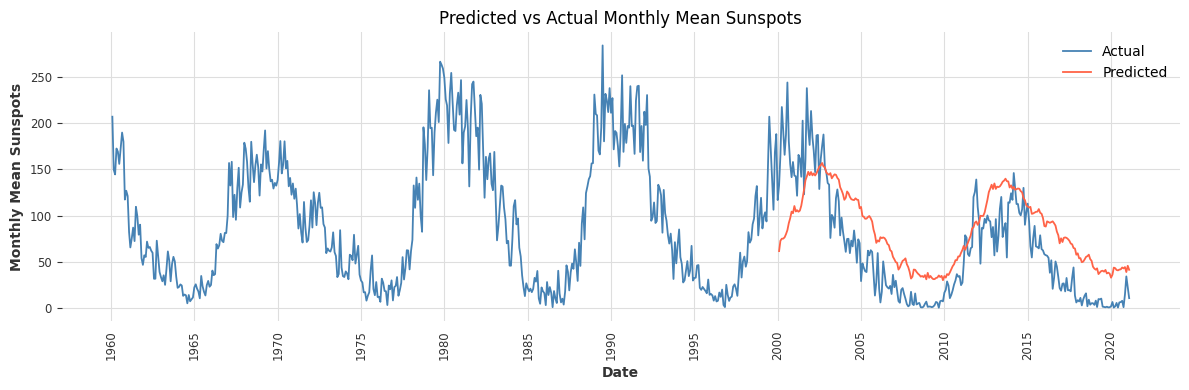

In [10]:
#passing the parameters for the model
#model parameters for training data till 2000
model_params_2000 = {'changepoint_prior_scale': 0.06, 
                     'decade_seasonality_prior_scale': 5.098, 
                     'decade_fourier_order': 17, 
                     'yearly_fourier_order': 18, 
                     'yearly_seasonality_prior_scale': 9.81}

#predicted series
pred_series_2000 = model_prophet(model_params_2000).fit(act_series_2000).predict(len(df_idx['2000':]))

#converted dataframe
df_pred_2000 = forecast_df(pred_series_2000)

#visualizing the prediction with the actual values
viz_forecast(df_pred_2000)

In [11]:
#Analysing the error in prediction
print("Average error in forecasting from 2000:",round(df_pred_2000['mae'].mean(),2))
print("Analysing error in forecasting from 2000:\n",df_pred_2000['mae'].describe())

Average error in forecasting from 2000: 37.86
Analysing error in forecasting from 2000:
 count    253.000000
mean      37.857487
std       21.513273
min        0.363400
25%       25.513453
50%       36.160339
75%       47.055148
max      160.113599
Name: mae, dtype: float64


## Model Prediction for Training Data till 2010

11:18:56 - cmdstanpy - INFO - Chain [1] start processing
11:18:57 - cmdstanpy - INFO - Chain [1] done processing


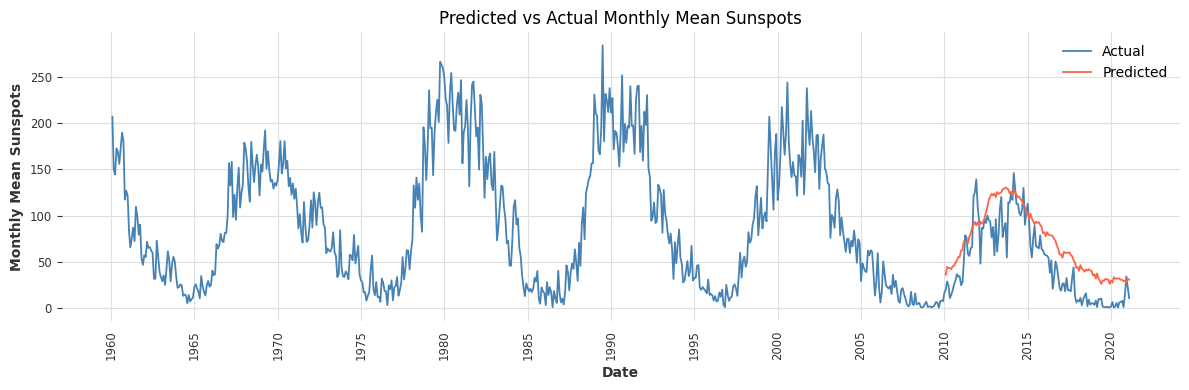

In [12]:
#passing the parameters for the model
#model parameters for training data till 2000
model_params_2010 = {'changepoint_prior_scale': 0.47, 
                     'decade_seasonality_prior_scale': 3.03, 
                     'decade_fourier_order': 14, 
                     'yearly_fourier_order': 7, 
                     'yearly_seasonality_prior_scale': 7.53}

#predicted series
pred_series_2010 = model_prophet(model_params_2010).fit(act_series_2010).predict(len(df_idx['2010':]))
df_pred_2010 = forecast_df(pred_series_2010)
viz_forecast(df_pred_2010)

In [13]:
#Analysing the error in prediction
print("Average error in forecasting from 2010:",round(df_pred_2010['mae'].mean(),2))
print("Analysing error in forecasting from 2010:\n",df_pred_2010['mae'].describe())

Average error in forecasting from 2010: 25.65
Analysing error in forecasting from 2010:
 count    133.000000
mean      25.650557
std       13.664997
min        0.871121
25%       16.991281
50%       25.517792
75%       34.150781
max       74.707683
Name: mae, dtype: float64
